In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from tqdm import tqdm

from IPython.display import clear_output

import torch
import torch.multiprocessing as mp
import torch.nn.functional as F
from torch.utils.data import ConcatDataset

PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd()))
sys.path.insert(0, PROJECT_DIR)

from dataloader.dataloader import CamLocDataset

# Vanilla dataloader

In [2]:
# Minimum sample for how the VANILLA dataloader should be called
trainset = CamLocDataset([os.path.join(PROJECT_DIR, 'datasets', 'urbanscape', 'train_drone_sim'),
                          os.path.join(PROJECT_DIR, 'datasets', 'urbanscape', 'train_drone_real')], 
                         coord=True, depth=True, normal=True, semantics=True, 
                         augment=False, raw_image=True)
trainset_loader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=12, 
                                              num_workers=mp.cpu_count(), pin_memory=True, collate_fn=trainset.batch_resize)

Dataloader 3D label flags: coord: True, depth: True, normal: True, semantics: True


In [3]:
for idx, batch_data in enumerate(trainset_loader):
    print("{:s} Data batch {:d} {:s}".format('='*20, idx, '='*20))
    for idx_item, item in enumerate(batch_data):
        print('Item {:d}, type: {}'.format(idx_item, type(item)))
        if isinstance(item, torch.Tensor):
            print("tensor shape: {}".format(item.shape))
        if isinstance(item, dict):
            for key, value in zip(item.keys(), item.values()):
                if isinstance(value, torch.Tensor):
                    print("Dict key: {}, value: {}".format(key, value.shape))
                else:
                    print("Dict key: {}, value: {}".format(key, value))
    if idx > 0:
        break

==================== Data batch 0 ====================
Item 0, type: <class 'torch.Tensor'>
tensor shape: torch.Size([12, 3, 480, 720])
Item 1, type: <class 'torch.Tensor'>
tensor shape: torch.Size([12, 4, 4])
Item 2, type: <class 'dict'>
Dict key: coord, value: torch.Size([12, 3, 60, 90])
Dict key: depth, value: torch.Size([12, 1, 60, 90])
Dict key: normal, value: torch.Size([12, 3, 60, 90])
Dict key: semantics, value: torch.Size([12, 1, 480, 720])
Item 3, type: <class 'torch.Tensor'>
tensor shape: torch.Size([12])
Item 4, type: <class 'list'>
==================== Data batch 1 ====================
Item 0, type: <class 'torch.Tensor'>
tensor shape: torch.Size([12, 3, 480, 720])
Item 1, type: <class 'torch.Tensor'>
tensor shape: torch.Size([12, 4, 4])
Item 2, type: <class 'dict'>
Dict key: coord, value: torch.Size([12, 3, 60, 90])
Dict key: depth, value: torch.Size([12, 1, 60, 90])
Dict key: normal, value: torch.Size([12, 3, 60, 90])
Dict key: semantics, value: torch.Size([12, 1, 480, 7

Idx: 0, filename: urbanscape/train_drone_real/rgb/EPFL-2020-11-11-planned_00435_100_0808_0248.png
Idx: 1, filename: urbanscape/train_drone_real/rgb/EPFL-2020-09-17-planned_00596_100_0039_0364.png
Idx: 2, filename: urbanscape/train_drone_real/rgb/EPFL-2020-11-11-planned_00099_100_0807_0100.png
Idx: 3, filename: urbanscape/train_drone_real/rgb/EPFL-2020-09-17-planned_00806_100_0040_0154.png
Idx: 4, filename: urbanscape/train_drone_real/rgb/EPFL-2020-09-17-piloted_00078_DJI_0110.png
Idx: 5, filename: urbanscape/train_drone_real/rgb/EPFL-2020-09-24-planned_00443_100_0002_0066.png
Idx: 6, filename: urbanscape/train_drone_sim/rgb/EPFL-2020-09-24-planned_00002_100_0001_0003.png
Idx: 7, filename: urbanscape/train_drone_sim/rgb/EPFL-2020-11-11-planned_00238_100_0808_0051.png
Idx: 8, filename: urbanscape/train_drone_real/rgb/EPFL-2020-09-17-planned_00739_100_0040_0087.png
Idx: 9, filename: urbanscape/train_drone_real/rgb/EPFL-2020-09-17-piloted_00134_DJI_0166.png
Idx: 10, filename: urbanscape/tr

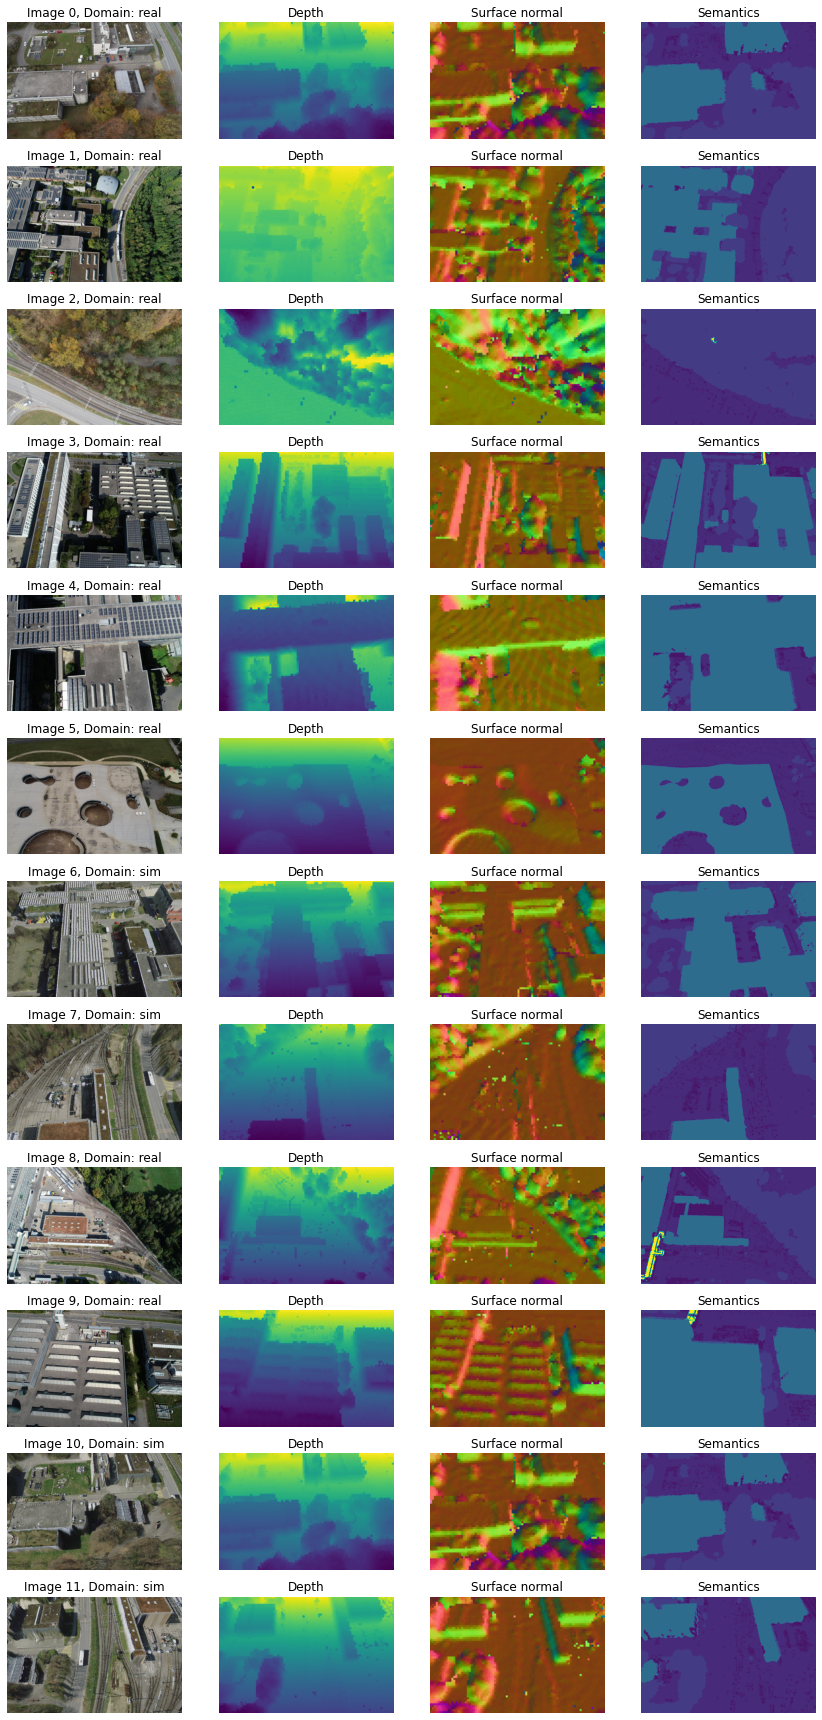

In [4]:
# Preview the datapoint
batch_size = len(batch_data[0])
fig, axes = plt.subplots(batch_size, 4, figsize=(12, batch_size*2))
for row in range(batch_size):
    for ax in axes[row]:
        ax.axis('off')
    img = batch_data[0][row].numpy().transpose(1, 2, 0)
    is_sim = '_sim' in os.path.basename(os.path.abspath(os.path.join(batch_data[4][row], '../..')))
    axes[row][0].imshow(img)
    axes[row][0].set_title("Image {:d}, Domain: {:s}".format(row, 'sim' if is_sim else 'real'))
    axes[row][1].imshow(batch_data[2]['depth'][row, 0].numpy())
    axes[row][1].set_title("Depth")

    normal = batch_data[2]['normal'][row].numpy().transpose(1, 2, 0).copy()
    normal += 1
    normal[np.sum(normal, axis=-1)!=-3] /= 2
    normal[np.sum(normal, axis=-1)!=-3] *= 255
    axes[row][2].imshow(normal.astype(np.uint8))
    axes[row][2].set_title("Surface normal")
    
    semantics = batch_data[2]['semantics'][row, 0].numpy()
    axes[row][3].imshow(batch_data[2]['semantics'][row, 0].numpy(), vmin=batch_data[2]['semantics'].min().item(), vmax=batch_data[2]['semantics'].max().item())
    axes[row][3].set_title("Semantics")
fig.tight_layout()

for idx, filename in enumerate(batch_data[4]):
    print("Idx: {:d}, filename: {:s}".format(idx, '/'.join(filename.split('/')[-4:])))